In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
dataset_path = '/content/drive/My Drive/LeatherDS/'
dataset2_path = '/content/drive/My Drive/cv_leather_500_splitted/'
dataset3_path = '/content/drive/My Drive/mvtec-kaggle-splitted/'

WORK_DIR = dataset_path
NUM_EPOCHS = 60
BATCH_SIZE = 256
LEARNING_RATE = 0.001
NUM_CLASSES = 6

In [ ]:
import torch
from torchvision.transforms import v2
from torchvision import datasets

transform = v2.Compose([
    v2.Resize((299, 299)),
    v2.ToImage(),
    v2.Grayscale(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = datasets.ImageFolder(root=dataset_path + 'train', transform=transform)
test_dataset = datasets.ImageFolder(root=dataset_path + 'test', transform=transform)
validation_dataset = datasets.ImageFolder(root=dataset_path + 'val', transform=transform)

In [ ]:
train_dataset2 = datasets.ImageFolder(root=dataset2_path + 'train', transform=transform)
test_dataset2 = datasets.ImageFolder(root=dataset2_path + 'test', transform=transform)
validation_dataset2 = datasets.ImageFolder(root=dataset2_path + 'val', transform=transform)

In [ ]:
train_dataset3 = datasets.ImageFolder(root=dataset3_path + 'train', transform=transform)
test_dataset3 = datasets.ImageFolder(root=dataset3_path + 'test', transform=transform)
validation_dataset3 = datasets.ImageFolder(root=dataset3_path + 'val', transform=transform)

In [ ]:
train_dev_sets = torch.utils.data.ConcatDataset([train_dataset, train_dataset2, train_dataset3])
test_dev_sets = torch.utils.data.ConcatDataset([test_dataset, test_dataset2, train_dataset3])
val_dev_sets = torch.utils.data.ConcatDataset([validation_dataset, validation_dataset2, train_dataset3])

In [ ]:
import torch
import torch.nn as nn

model = torch.hub.load('pytorch/vision:v0.18.1', 'inception_v3', weights='Inception_V3_Weights.DEFAULT')
model.aux_logits = False
model.eval()

model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

Downloading: "https://github.com/pytorch/vision/zipball/v0.18.1" to /root/.cache/torch/hub/v0.18.1.zip
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 174MB/s] 


In [ ]:
import torch.nn as nn

#const to change
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)


In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dev_sets, batch_size=BATCH_SIZE, shuffle=True, num_workers = 2)
test_loader = DataLoader(test_dev_sets, batch_size=BATCH_SIZE, shuffle=False, num_workers = 2)
val_loader = DataLoader(val_dev_sets, batch_size=BATCH_SIZE, shuffle=False, num_workers = 2)


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
#evaluacija
def evaluate_model(model, loader, device):
    model.eval()
    all_labels = []
    all_preds = []
    total_loss = 0.0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    all_preds_rounded = np.round(all_preds)
    cm = confusion_matrix(all_labels, all_preds_rounded)
    return avg_loss, accuracy, precision, recall, f1, cm

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Definisanje funkcije za iscrtavanje matrice konfuzije u boji
def plot_confusion_matrix(cm, labels, title='Matrica konfuzije', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=labels, yticklabels=labels)
    plt.xlabel('Pogodjena anotacija')
    plt.ylabel('Stvarna anotacija')
    plt.title(title)
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
from torch.cuda.amp import autocast, GradScaler
import copy


scaler = GradScaler()

train_losses = []
valid_losses = []
loss = 0
data = 0
target = 0
output = 0
best_loss = float('inf')
best_model_weights = None
patience = 10

for epoch in range(1, NUM_EPOCHS + 1):
    train_loss = 0.0
    valid_loss = 0.0
    valid_loss_eval = 0

    # training-the-model
    model.train()
    for data, target in train_loader:
        # move-tensors-to-GPU
        data = data.to(device)
        target = target.to(device)

        # clear-the-gradients-of-all-optimized-variables
        optimizer.zero_grad()

        # GPU relevant Mixed Precision Training
        with autocast():
            outputs = model(data)
            loss = criterion(outputs, target)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update-training-loss
        train_loss += loss.item()

    # validate-the-model
    model.eval()
    with torch.no_grad():
        all_labels = []
        all_preds = []
        for data_eval, target_eval in val_loader:

            data_eval = data_eval.to(device)
            target_eval = target_eval.to(device)

            output_eval = model(data_eval)
            loss_eval = criterion(output_eval, target_eval)

            # update-average-validation-loss
            valid_loss_eval += loss_eval.item()

    # Early stopping
    if loss_eval < best_loss:
        best_loss = loss_eval
        best_model_weights = copy.deepcopy(model.state_dict())  # Deep copy here
        patience = 10  # Reset patience counter
    else:
        patience -= 1
        if patience == 0:
            torch.save(model.state_dict(), '/content/drive/MyDrive/inception_v3_leather_balansed_mixed_ds_' + str(epoch) + '.pth')
            break


    # calculate-average-losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss_eval/len(val_loader.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    # print-training/validation-statistics
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))


# Evaluacija na testnom skupu
test_loss, test_accuracy, test_precision, test_recall, test_f1, test_cm = evaluate_model(model, test_loader, device)
print(f'Test Loss: {test_loss:.4f}, '
      f'Test Accuracy: {test_accuracy:.4f}, '
      f'Test Precision: {test_precision:.4f}, '
      f'Test Recall: {test_recall:.4f}, '
      f'Test F1-score: {test_f1:.4f}')
print(f'Test Confusion Matrix:\n{test_cm}')

# Evaluacija na validacijskom skupu
val_loss, val_accuracy, val_precision, val_recall, val_f1, val_cm = evaluate_model(model, val_loader, device)
print(f'Validation Loss: {val_loss:.4f}, '
      f'Validation Accuracy: {val_accuracy:.4f}, '
      f'Validation Precision: {val_precision:.4f}, '
      f'Validation Recall: {val_recall:.4f}, '
      f'Validation F1-score: {val_f1:.4f}')
print(f'Validation Confusion Matrix:\n{val_cm}')

Epoch: 1 	Training Loss: 0.008308 	Validation Loss: 0.005963
Epoch: 2 	Training Loss: 0.004962 	Validation Loss: 0.005213


KeyboardInterrupt: 

In [ ]:
#Iscrtavanje matrice konfuzije za testni skup
labels = ['discoloration','micro_defect','reperable_defect','structural_irreperable_defect','textural_defect','undamaged']


plot_confusion_matrix(test_cm, labels, title='Matrica konfuzije seta za testiranje')

# Iscrtavanje matrice konfuzije za validacioni skup
plot_confusion_matrix(val_cm, labels, title='Matrica konfuzije seta za validaciju')

#save last model
torch.save(model.state_dict(), '/content/drive/MyDrive/inception_v3_with_weights_for_leather_checkpoint_balansed_ds_new.pth')


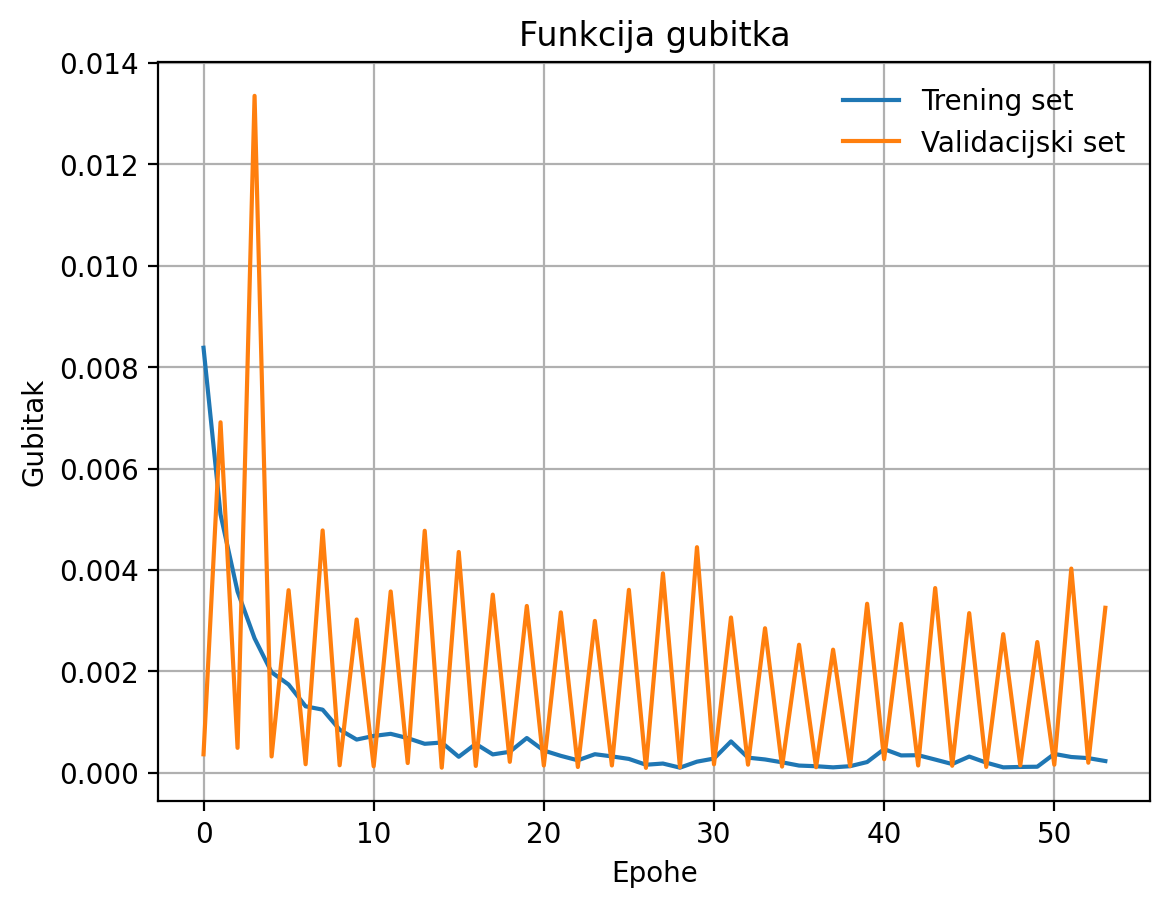

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Trening set')
plt.plot(valid_losses, label='Validacijski set')
plt.xlabel("Epohe")
plt.ylabel("Gubitak")
plt.title("Funkcija gubitka")
plt.grid()
plt.legend(frameon=False)